#Setup and preprocessing

In [1]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/MyDrive/bis_project

/gdrive/.shortcut-targets-by-id/1I7Sz2Z9huBbMrPdHrCzeiIFqOv3CkrpT/bis_project


In [3]:
!cp submit.zip /content

In [4]:
%cd /content

/content


In [5]:
# unzip at every run to have ready all images (content is cleaned at any new session)
!unzip submit.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: submit/train/wildfire/2896872.jpg  
  inflating: submit/train/wildfire/2896873.jpg  
  inflating: submit/train/wildfire/2896874.jpg  
  inflating: submit/train/wildfire/2896876.jpg  
  inflating: submit/train/wildfire/2896877.jpg  
  inflating: submit/train/wildfire/2896878.jpg  
  inflating: submit/train/wildfire/2896879.jpg  
  inflating: submit/train/wildfire/2896880.JPG  
  inflating: submit/train/wildfire/2896881.jpg  
  inflating: submit/train/wildfire/2896882.jpg  
  inflating: submit/train/wildfire/2896883.jpg  
  inflating: submit/train/wildfire/2896884.jpg  
  inflating: submit/train/wildfire/2896885.jpg  
  inflating: submit/train/wildfire/2896886.png  
  inflating: submit/train/wildfire/2896887.jpg  
  inflating: submit/train/wildfire/2896888.jpg  
  inflating: submit/train/wildfire/2896889.jpeg  
  inflating: submit/train/wildfire/2896890.jpg  
  inflating: submit/train/wildfire/2896891.jpg  
  inflating: submi

In [6]:
### This script convert all the .png images in jpeg

import os
from PIL import Image

# Define the path to your submit folder
submit_folder = 'submit'

# Iterate through each subfolder (train, val, test)
for subfolder in ['train', 'val', 'test']:
    subfolder_path = os.path.join(submit_folder, subfolder)

    # Iterate through each category subfolder (cyclone, flood, earthquake, volcano, wildfire)
    for category in ['cyclone', 'flood', 'earthquake', 'volcano', 'wildfire']:
        category_path = os.path.join(subfolder_path, category)

        # Iterate through each .png file in the category subfolder
        for filename in os.listdir(category_path):
            if filename.endswith('.png'):
                image_path = os.path.join(category_path, filename)
                image = Image.open(image_path)
                if image.mode == 'RGBA':
                    # Convert RGBA image to RGB
                    image = image.convert('RGB')
                elif image.mode == 'P':
                    # Convert grayscale image to RGB
                    image = image.convert('RGB')
                jpg_path = os.path.join(category_path, filename[:-4] + '.jpg')
                image.save(jpg_path)
                image.close()
                os.remove(image_path)


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [7]:
### This script is used for create the 1 vs n classes folder

import os
import random
import shutil
import uuid

selected = 'volcano'
folders = ["test", "train", "val"]
classes = ["cyclone", "earthquake", "flood", "volcano", "wildfire"]

# Count the number of images in the "cyclone" class for each folder (train, val, test)
for folder in folders:
    cyclone_path = f"submit/{folder}/{selected}"  # Path to the cyclone class folder
    num_cyclone_images = len(os.listdir(cyclone_path))
    print(f"Number of cyclone images in {folder}: {num_cyclone_images}")

    # Create a new directory named "others" inside each folder (train, val, test)
    others_path = f"submit/{folder}/others"  # Path to the new "others" folder
    os.makedirs(others_path, exist_ok=True)

    # Determine the target number of images for each remaining class in each folder
    remaining_classes = ["earthquake", "cyclone", "flood", "wildfire"]
    num_remaining_classes = len(remaining_classes)
    num_cyclone_images = len(os.listdir(f"submit/{folder}/{selected}"))
    target_num_per_class = (num_cyclone_images // num_remaining_classes) + 1

    # Iterate over the remaining classes, select a subset of images, 
    # and move them to the "others" folder in each folder:
    for class_name in remaining_classes:
        class_path = f"submit/{folder}/{class_name}"
        images = os.listdir(class_path)
        random.shuffle(images)  # Randomly shuffle the image list

        # Select the desired number of images from the current class
        selected_images = images[:target_num_per_class]

        # Move the selected images to the "others" folder
        for image in selected_images:
            src = os.path.join(class_path, image)
            unique_filename = f"{uuid.uuid4().hex}_{image}"
            dst = os.path.join(f"submit/{folder}/others", unique_filename)
            shutil.move(src, dst)

        # Delete the remaining class folders (excluding the "cyclone" folder) in each folder 
        class_path = f"submit/{folder}/{class_name}"
        shutil.rmtree(class_path)

Number of cyclone images in test: 512
Number of cyclone images in train: 3832
Number of cyclone images in val: 766


In [8]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
# from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import random
import os
import tensorflow as tf
from PIL import Image

In [9]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [16]:
# Dataset folders 
dataset_dir = '/content/submit'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')
print(training_dir)
labels = ['others', 'volcano']

/content/submit/train


Text(0.5, 1.0, 'Number of training images per category:')

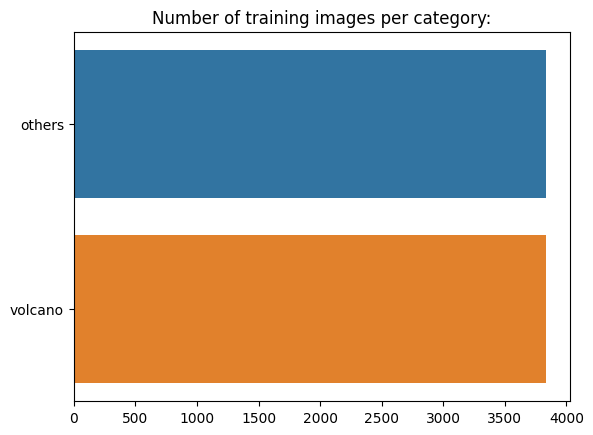

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
category_names = sorted(os.listdir(training_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = training_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

## Preprocessing

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

# Create an instance of ImageDataGenerator with Data Augmentation
# Note that commets line are for here for old augmentations maybe not neccessary in future

aug_train_data_gen = ImageDataGenerator(#rotation_range=180,
                                        #height_shift_range=5,
                                        #width_shift_range=5,
                                        #zoom_range=0.5,
                                        #horizontal_flip=True,
                                        #vertical_flip=True, 
                                        #fill_mode='constant',
                                        preprocessing_function = preprocess_input,
                                        # rescale=1/255. not on vgg16
                                        ) 
valid_data_gen = ImageDataGenerator(#rescale=1/255.,
                                    preprocessing_function = preprocess_input
                                    )
test_data_gen = ImageDataGenerator(#rescale=1/255.,
                                   preprocessing_function = preprocess_input
                                   )

In [19]:
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(256,256),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(256,256),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False,
                                             seed=seed)

Found 7668 images belonging to 2 classes.
Found 1534 images belonging to 2 classes.
Found 1028 images belonging to 2 classes.


In [20]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (32, 256, 256, 3)
Target shape: (32, 2)

Categorical label: [1. 0.]
Label: 0
Class name: others


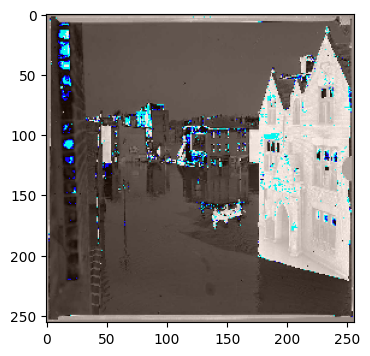

In [21]:
# Get a sample from dataset and show info
_ = get_next_batch(aug_train_gen)

#Train

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):
      
  callbacks = []

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [22]:
# Download and plot the ResNet50 model
supernet = tfk.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3)
)
supernet.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
input_shape = (256, 256, 3)
epochs = 20

In [23]:
import tensorflow.keras.layers as tfkl

# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(256,256,3))
# No resize
x = supernet(inputs)

x = tfkl.BatchNormalization()(x)  # Add batch normalization layer
x = tfkl.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer=tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.BatchNormalization()(x)

x = tfkl.GlobalAveragePooling2D()(x)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.2, seed=seed)(x)

x = tfkl.Dense(256, activation='relu', kernel_initializer=tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.2, seed=seed)(x)

output_layer = tfkl.Dense(units=2, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)

# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

# Compile the model
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 2048)       8192      
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 256)         4718848   
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 256)        1024      
 hNormalization)                                                 
                                                                 
 global_average_pooling2d (G  (None, 256)              0     

In [ ]:
for i, layer in enumerate(tl_model.get_layer('resnet50').layers):
   layer.trainable = False

for i, layer in enumerate(tl_model.get_layer('resnet50').layers):
   print(i, layer.name, layer.trainable)

0 input_7 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [ ]:
# Train the model
tl_callbacks = create_folders_and_callbacks(model_name = 'resnet50_first')

# Train the model
tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = tl_callbacks
).history

Epoch 1/20
228/228 [==============================] - 313s 1s/step - loss: 3.7394 - accuracy: 0.8645 - precision_4: 0.8645 - recall_4: 0.8645 - val_loss: 1.4754 - val_accuracy: 0.8932 - val_precision_4: 0.8932 - val_recall_4: 0.8932
Epoch 2/20
228/228 [==============================] - 296s 1s/step - loss: 1.1336 - accuracy: 0.8903 - precision_4: 0.8903 - recall_4: 0.8903 - val_loss: 0.8823 - val_accuracy: 0.9087 - val_precision_4: 0.9087 - val_recall_4: 0.9087
Epoch 3/20
228/228 [==============================] - 291s 1s/step - loss: 0.7766 - accuracy: 0.8951 - precision_4: 0.8951 - recall_4: 0.8951 - val_loss: 0.6387 - val_accuracy: 0.9128 - val_precision_4: 0.9128 - val_recall_4: 0.9128
Epoch 4/20
228/228 [==============================] - 291s 1s/step - loss: 0.6563 - accuracy: 0.8933 - precision_4: 0.8933 - recall_4: 0.8933 - val_loss: 0.5875 - val_accuracy: 0.9128 - val_precision_4: 0.9128 - val_recall_4: 0.9128
Epoch 5/20
228/228 [==============================] - 293s 1s/step -

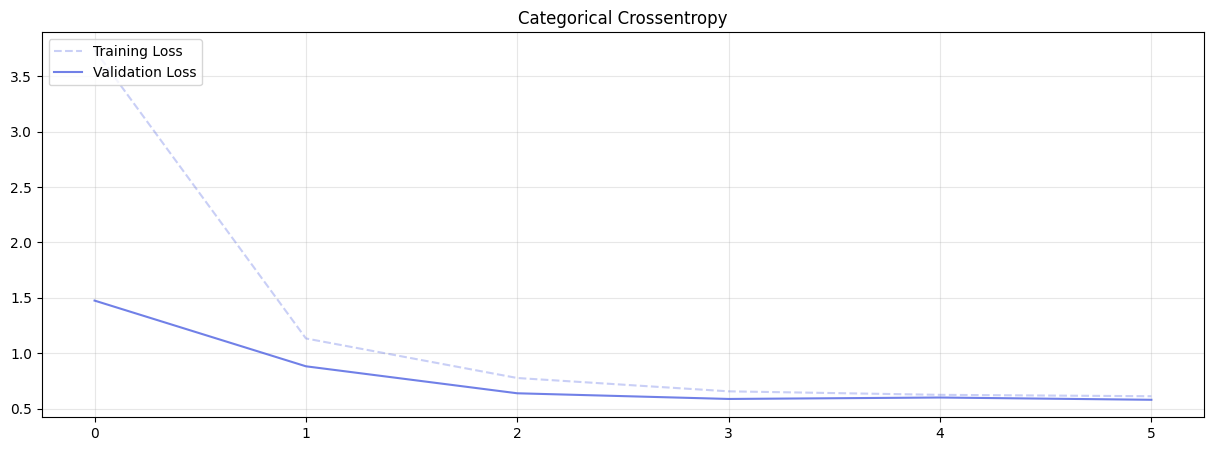

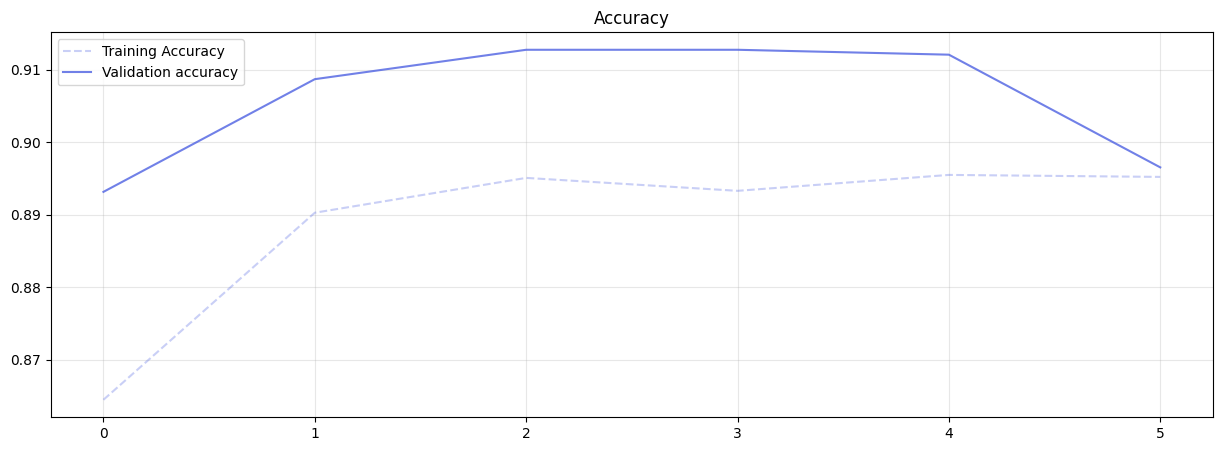

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
import shutil
# Define the folder path where you want to save the model file
folder_path = '/gdrive/MyDrive/bis_project/'

# Define the name of the model file
model_name = 'only_cyclone.h5'

# Save the model to a file
tl_model.save(model_name)

# Move the model file to your Google Drive folder
shutil.copy(model_name, folder_path)

print(f'Successfully saved {model_name} to {folder_path}')

Successfully saved only_cyclone.h5 to /gdrive/MyDrive/bis_project/


#Load the model

In [ ]:
%cd /gdrive/MyDrive/bis_project

/gdrive/.shortcut-targets-by-id/1I7Sz2Z9huBbMrPdHrCzeiIFqOv3CkrpT/bis_project


In [ ]:
from tensorflow.keras.models import load_model
tl_model=load_model('only_cyclone.h5')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 batch_normalization_6 (Batc  (None, 8, 8, 2048)       8192      
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         4718848   
                                                                 
 batch_normalization_7 (Batc  (None, 8, 8, 256)        1024      
 hNormalization)                                                 
                                                                 
 global_average_pooling2d_3   (None, 256)              0     

# Fine Tuning

In [24]:
tl_model.get_layer('resnet50').trainable = True
for i, layer in enumerate(tl_model.get_layer('resnet50').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 conv1_pad True
2 conv1_conv True
3 conv1_bn True
4 conv1_relu True
5 pool1_pad True
6 pool1_pool True
7 conv2_block1_1_conv True
8 conv2_block1_1_bn True
9 conv2_block1_1_relu True
10 conv2_block1_2_conv True
11 conv2_block1_2_bn True
12 conv2_block1_2_relu True
13 conv2_block1_0_conv True
14 conv2_block1_3_conv True
15 conv2_block1_0_bn True
16 conv2_block1_3_bn True
17 conv2_block1_add True
18 conv2_block1_out True
19 conv2_block2_1_conv True
20 conv2_block2_1_bn True
21 conv2_block2_1_relu True
22 conv2_block2_2_conv True
23 conv2_block2_2_bn True
24 conv2_block2_2_relu True
25 conv2_block2_3_conv True
26 conv2_block2_3_bn True
27 conv2_block2_add True
28 conv2_block2_out True
29 conv2_block3_1_conv True
30 conv2_block3_1_bn True
31 conv2_block3_1_relu True
32 conv2_block3_2_conv True
33 conv2_block3_2_bn True
34 conv2_block3_2_relu True
35 conv2_block3_3_conv True
36 conv2_block3_3_bn True
37 conv2_block3_add True
38 conv2_block3_out True
39 conv3_block1_1_conv Tru

In [25]:
for i, layer in enumerate(tl_model.get_layer('resnet50').layers[:125]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('resnet50').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [26]:
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
# Fine-tune the model
tl_history = tl_model.fit(
    x = aug_train_gen ,
    batch_size = 32,
    epochs = 20,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=2 , restore_best_weights=True)],
).history

Epoch 1/20
240/240 [==============================] - 268s 983ms/step - loss: 0.1586 - accuracy: 0.9431 - precision_1: 0.9431 - recall_1: 0.9431 - val_loss: 0.1074 - val_accuracy: 0.9635 - val_precision_1: 0.9635 - val_recall_1: 0.9635
Epoch 2/20
240/240 [==============================] - 210s 875ms/step - loss: 0.0523 - accuracy: 0.9834 - precision_1: 0.9834 - recall_1: 0.9834 - val_loss: 0.1025 - val_accuracy: 0.9661 - val_precision_1: 0.9661 - val_recall_1: 0.9661
Epoch 3/20
240/240 [==============================] - 207s 864ms/step - loss: 0.0285 - accuracy: 0.9903 - precision_1: 0.9903 - recall_1: 0.9903 - val_loss: 0.0788 - val_accuracy: 0.9765 - val_precision_1: 0.9765 - val_recall_1: 0.9765
Epoch 4/20
 47/240 [====>.........................] - ETA: 2:18 - loss: 0.0209 - accuracy: 0.9920 - precision_1: 0.9920 - recall_1: 0.9920

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
%cd /gdrive/MyDrive/bis_project

In [ ]:
import shutil
# Define the folder path where you want to save the model file
folder_path = '/gdrive/MyDrive/bis_project'

# Define the name of the model file
model_name = 'volcano_ft.h5'

# Save the model to a file
tl_model.save(model_name)

print(f'Successfully saved {model_name} to {folder_path}')

#Test on the test set from the generator

In [ ]:
# Test the model
model_test_metrics = tl_model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics")
print(model_test_metrics)

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = tl_model.predict_generator(test_gen, steps=224)
predicted_classes = np.argmax(predictions, axis=-1)

# Compute the confusion matrix
cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from PIL import Image

# Assuming your model object is called 'model' and test_gen object is called 'test_gen'
class_labels = ['cyclone','others'] # list of class labels

# Get the next batch of images and labels from test_gen
batch = next(test_gen)

# Select the first image in the batch
img = batch[0][0]

# Convert the image from PIL Image to NumPy array
img_arr = img_to_array(img)

# Preprocess the image
img_arr = preprocess_input(img_arr)

# Convert the NumPy array back to a PIL Image object
img = Image.fromarray(np.clip(img_arr + 127.5, 0, 255).astype(np.uint8))

# Predict class probabilities for the image
probs = tl_model.predict(np.expand_dims(img_arr, axis=0))

# Plot the image and accuracy scores for each class
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
ax1.imshow(img)
ax1.axis('off')
ax2.bar(np.arange(len(class_labels)), probs[0])
ax2.set_xticks(np.arange(len(class_labels)))
ax2.set_xticklabels(class_labels)
ax2.set_title('Accuracy Scores for Image')
ax2.set_xlabel('Class')
ax2.set_ylabel('Accuracy Score')
plt.show()


# Ensamble 

In [ ]:
%cd /gdrive/MyDrive/bis_project

/gdrive/.shortcut-targets-by-id/1I7Sz2Z9huBbMrPdHrCzeiIFqOv3CkrpT/bis_project


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
# Load the different model

model1=load_model('resnet_.h5')
model2=load_model('tlft13_model.h5')
model3=load_model('tl_model_gap.h5')
model5=load_model('norm_gap_dense.h5')

In [ ]:
# Initialize empty lists to store predictions from each model
probabilities_model1 = []
probabilities_model2 = []
probabilities_model3 = []
probabilities_model5 = []

N = 2540
ground_truth_labels = test_gen.classes

In [ ]:
# Do the predicton
predictions1 = model1.predict(test_gen, steps=N//32+1)
predictions2 = model2.predict(test_gen, steps=N//32+1)
predictions3 = model3.predict(test_gen, steps=N//32+1)
predictions5 = model5.predict(test_gen, steps=N//32+1)

# Save the predicted label
predicted_labels1 = np.argmax(predictions1, axis=1)
predicted_labels2 = np.argmax(predictions2, axis=1)
predicted_labels3 = np.argmax(predictions3, axis=1)
predicted_labels5 = np.argmax(predictions5, axis=1)

# Print classification report
accuracy = accuracy_score(ground_truth_labels, predicted_labels1)
print(f"Model 1 Accuracy: {accuracy}")
accuracy = accuracy_score(ground_truth_labels, predicted_labels2)
print(f"Model 2 Accuracy: {accuracy}")
accuracy = accuracy_score(ground_truth_labels, predicted_labels3)
print(f"Model 3 Accuracy: {accuracy}")
accuracy = accuracy_score(ground_truth_labels, predicted_labels5)
print(f"Model 5 Accuracy: {accuracy}")

80/80 [==============================] - 68s 804ms/step
Model 1 Accuracy: 0.9409448818897638
Model 2 Accuracy: 0.9405511811023622
Model 3 Accuracy: 0.9173228346456693
Model 4 Accuracy: 0.14921259842519685
Model 5 Accuracy: 0.9287401574803149


In [ ]:
ensemble_predictions = np.argmax(predictions1 + predictions2 + predictions3 + predictions5, axis=1)
majority_vote = np.argmax(np.bincount(ensemble_predictions))

# Print classification report
print("Ensemble Classification Report:")
print(classification_report(ground_truth_labels, ensemble_predictions))

# Print confusion matrix
print("Ensemble Confusion Matrix:")
print(confusion_matrix(ground_truth_labels, ensemble_predictions))

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       486
           1       0.94      0.96      0.95       517
           2       0.93      0.96      0.94       520
           3       0.96      0.97      0.96       509
           4       0.96      0.97      0.97       508

    accuracy                           0.95      2540
   macro avg       0.95      0.95      0.95      2540
weighted avg       0.95      0.95      0.95      2540

Ensemble Confusion Matrix:
[[427  22  26   9   2]
 [ 11 496   9   1   0]
 [ 10   8 498   1   3]
 [  0   0   2 492  15]
 [  2   1   0  10 495]]
